# Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to /home/hichem-
[nltk_data]     semmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [3]:
data = pd.read_csv('complaints.csv', engine='python', encoding='utf-8', on_bad_lines="skip", sep=',')

In [4]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-10-13,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",IL,60484,NaN,NaN,Web,2022-10-13,In progress,Yes,NaN,6080775
1,2022-10-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33157,NaN,NaN,Web,2022-10-13,In progress,Yes,NaN,6080615
2,2022-10-12,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,NaN,Experian Information Solutions Inc.,TN,37066,NaN,NaN,Web,2022-10-12,In progress,Yes,NaN,6075659
3,2022-10-12,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,NaN,"EQUIFAX, INC.",CO,80207,NaN,NaN,Web,2022-10-12,In progress,Yes,NaN,6075696
4,2022-10-13,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",SC,29045,NaN,NaN,Web,2022-10-13,In progress,Yes,NaN,6080975


In [5]:
data = data[["Product","Consumer complaint narrative"]]

In [6]:
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,"Credit reporting, credit repair services, or o...",NaN
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,"Credit reporting, credit repair services, or o...",NaN


In [7]:
data.isna().sum()

Product                               0
Consumer complaint narrative    1922857
dtype: int64

In [8]:
data.dropna(subset=['Consumer complaint narrative'], inplace=True)
print(len(data))
print(data.isna().sum())

1074546
Product                         0
Consumer complaint narrative    0
dtype: int64


In [9]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    487882
Debt collection                                                                 188742
Mortgage                                                                         96559
Credit card or prepaid card                                                      79254
Checking or savings account                                                      52143
Student loan                                                                     32061
Credit reporting                                                                 31588
Money transfer, virtual currency, or money service                               25623
Vehicle loan or lease                                                            19315
Credit card                                                                      18838
Bank account or service                                                          14885
Payday loan, title loan, or personal loan  

<AxesSubplot:>

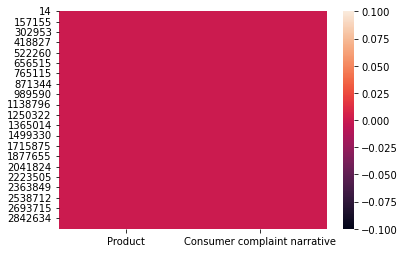

In [10]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [11]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [12]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    519470
Debt collection                                                                 188742
Credit card or prepaid card                                                      98092
Mortgage                                                                         96559
Checking or savings account                                                      52143
Student loan                                                                     32061
Money transfer, virtual currency, or money service                               25639
Vehicle loan or lease                                                            19315
Payday loan, title loan, or personal loan                                        14931
Bank account or service                                                          14885
Consumer Loan                                                                     9470
Money transfers                            

In [13]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"

# CODE HERE
data.loc[data['Product'] == 'Prepaid card'] = 'Other financial service'
data.loc[data['Product'] == 'Consumer Loan'] = 'Other financial service'
data.loc[data['Product'] == 'Bank account or service']  = 'Other financial service'



In [14]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    519470
Debt collection                                                                 188742
Credit card or prepaid card                                                      98092
Mortgage                                                                         96559
Checking or savings account                                                      52143
Student loan                                                                     32061
Other financial service                                                          26097
Money transfer, virtual currency, or money service                               25639
Vehicle loan or lease                                                            19315
Payday loan, title loan, or personal loan                                        14931
Money transfers                                                                   1497
Name: Product, dtype: int64

In [15]:
# We will not consider other financial service
data = data[data.Product != 'Other financial service']

In [16]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    519470
Debt collection                                                                 188742
Credit card or prepaid card                                                      98092
Mortgage                                                                         96559
Checking or savings account                                                      52143
Student loan                                                                     32061
Money transfer, virtual currency, or money service                               25639
Vehicle loan or lease                                                            19315
Payday loan, title loan, or personal loan                                        14931
Money transfers                                                                   1497
Name: Product, dtype: int64

In [17]:
data = data.reset_index(drop=True)

In [18]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",I was a victim of identity theft and this is a...
1,Credit card or prepaid card,Filed a dispute with Citi for a service which ...
2,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
3,"Credit reporting, credit repair services, or o...",In accordance with the FCRA Everything has to ...
4,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
...,...,...
1048444,Credit card or prepaid card,"Automated calls from "" XXXX with Capital One '..."
1048445,Debt collection,I have disputed my debts several times with no...
1048446,Mortgage,My father died in XX/XX/XXXX. Left me his only...
1048447,"Credit reporting, credit repair services, or o...",cfbp i would Like to file a complaint on Exper...


In [19]:
len(data.Product.value_counts())

10

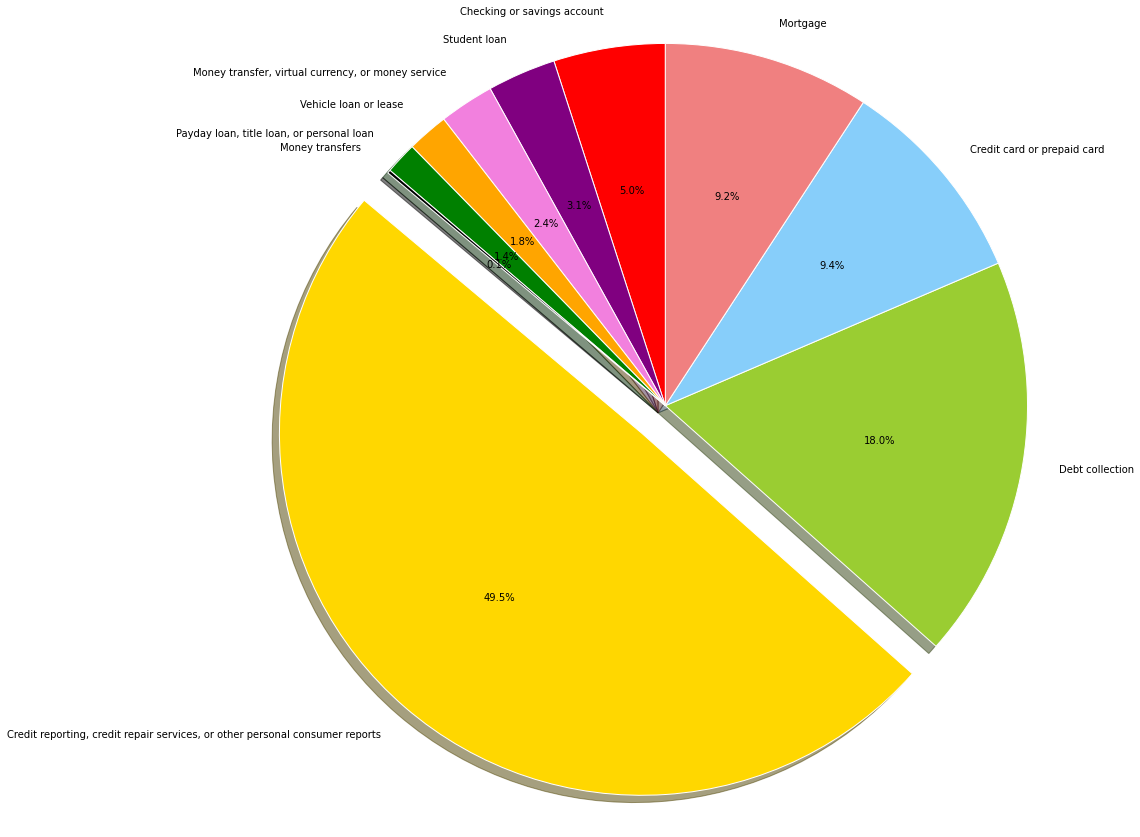

In [75]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green', 'black']
explode = (0.1, 0, 0, 0,0,0,0,0,0, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(15,15))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [20]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [21]:
complaint_product(238, data)

This is my 2nd request that I have been a victim of identity theft and that no one seems to care, that I want to dispute specific records in my credit file that do not belong to me, or that I have signed any agreement. The items I'm challenging have nothing to do with any transactions I've done or authorized to gain products, services, or money. Please remove the following items : XXXX XXXX XXXX XXXX XXXX XXXX XXXX, GA XXXX XXXX XXXX XXXX XXXX : {$0.00} XXXX XXXX ( Original Creditor : XXXX XXXX XXXX XXXX XXXX XXXX XXXX Balance : {$3800.00} XXXX XX/XX/XXXX XXXX XX/XX/XXXX XXXX XX/XX/XXXX RENEWAL BY A XX/XX/XXXX XXXX XX/XX/XXXX XXXX XXXX XX/XX/XXXX XXXX XXXX XXXX  XX/XX/XXXX
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [22]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [23]:
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",I was a victim of identity theft and this is a...
1,Credit card or prepaid card,Filed a dispute with Citi for a service which ...
2,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
3,"Credit reporting, credit repair services, or o...",In accordance with the FCRA Everything has to ...
4,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...


In [24]:
# Code Here
data['Consumer complaint narrative'] = data.apply(lambda row: clean_text(row['Consumer complaint narrative']), axis=1)

In [96]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",victim identity theft another request block re...
1,Credit card or prepaid card,filed dispute citi service performed poorly da...
2,"Credit reporting, credit repair services, or o...",accordance fair credit reporting act list acco...
3,"Credit reporting, credit repair services, or o...",accordance fcra everything accurate credit rep...
4,"Credit reporting, credit repair services, or o...",accordance fair credit reporting act georgia i...
...,...,...
1048444,Credit card or prepaid card,automated calls capital one calls home phone e...
1048445,Debt collection,disputed debts several times resolution submit...
1048446,Mortgage,father died left son belongings also single mo...
1048447,"Credit reporting, credit repair services, or o...",cfbp would like file complaint eperian reporti...


In [98]:
# After cleaning
complaint_product(228, data)

stating transunion violating usc permissible purposes consumer reports states consumer reporting agency transunion may furnish consumer report accordance written instructions consumer never gave transunion written consent report information consumer report since gave consent indeed identity theft since provide consent demanding proceed remove accounts listed transunion credit report choose remove items credit report etend credit anyone give transunion permission furnish credit report additionally pursuant usc banking system fully dependent firmly braise fair accurate consumer reports transunion violating law reporting inaccuracies credit report hence causing lose confidence banking system transunion wants continue business need delete inaccurate accounts transunion consumer report epeditiously etremely litigious consumer well please respond identification verification indeed
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer r

In [ ]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [25]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]

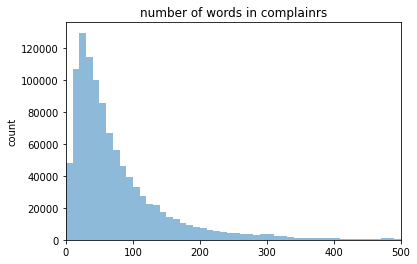

In [26]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

/home/hichem-semmar/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

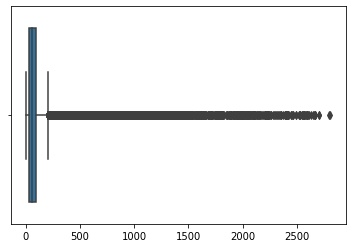

In [27]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [30]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 259755 unique tokens.


In [31]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1048449, 250)


In [32]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1048449, 10)


In [63]:
# Code Here
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 123)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(733914, 250) (733914, 10)
(314535, 250) (314535, 10)


**Expected Output :**
(35449, 250) (35449, 9)
(8863, 250) (8863, 9)

In [58]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [68]:
## MINIMIZE THE TRAINNING DURATION
X_train_reduced, X_test_reduced, Y_train_reduced, Y_test_reduced = train_test_split(
    X_train, Y_train, test_size=0.95, random_state=123)

In [69]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train_reduced,
                    Y_train_reduced,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[
                        EarlyStopping(monitor='val_loss',
                                      patience=3,
                                      min_delta=0.0001)
                    ])

Epoch 1/5


2022-10-15 16:31:21.829577: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33025000 exceeds 10% of free system memory.


517/517 [==============================] - 190s 367ms/step - loss: 0.8945 - accuracy: 0.7175 - val_loss: 0.7554 - val_accuracy: 0.7589
Epoch 2/5
517/517 [==============================] - 184s 355ms/step - loss: 0.7094 - accuracy: 0.7751 - val_loss: 0.9388 - val_accuracy: 0.7120
Epoch 3/5
517/517 [==============================] - 185s 358ms/step - loss: 0.6753 - accuracy: 0.7889 - val_loss: 0.6891 - val_accuracy: 0.7804
Epoch 4/5
517/517 [==============================] - 183s 355ms/step - loss: 0.6182 - accuracy: 0.8041 - val_loss: 0.6676 - val_accuracy: 0.7918
Epoch 5/5
517/517 [==============================] - 184s 356ms/step - loss: 0.5566 - accuracy: 0.8267 - val_loss: 0.6734 - val_accuracy: 0.7918


In [70]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

Test set
  Loss: 0.67
  Accuracy: 0.79


In [0]:
# evaluate model on test set
# Code Here
score = None
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

Test set

  Loss: 0.66
  
  Accuracy: 0.80

In [71]:
Y_pred = model.predict(X_test)

In [72]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [82]:
# Code Here
expected_classes = np.argmax(Y_test, axis=1)

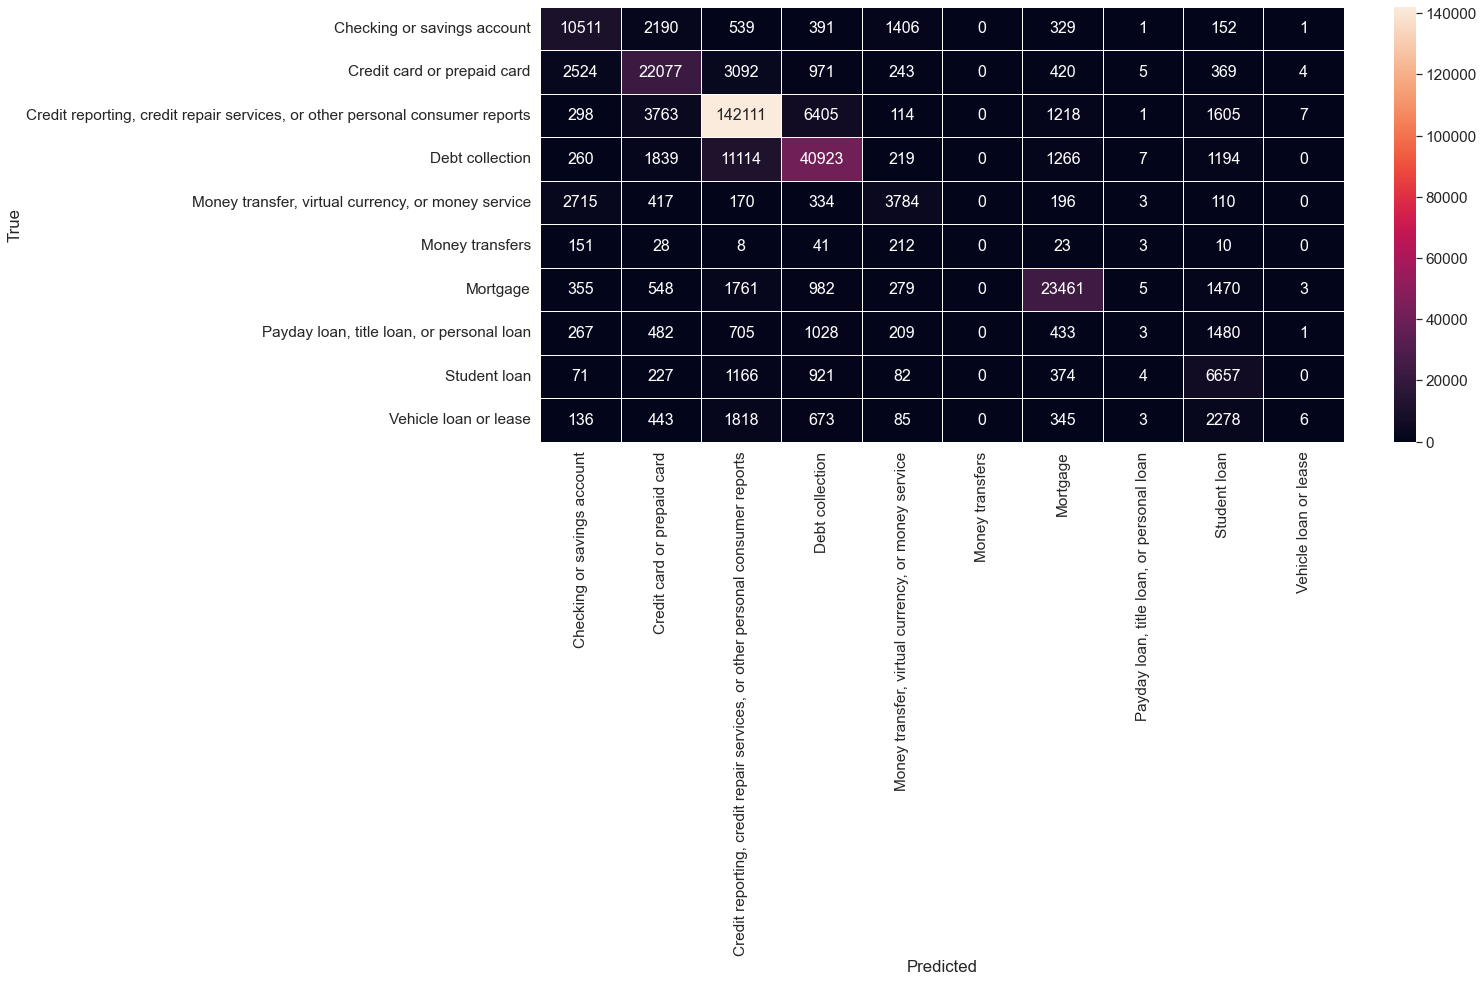

In [83]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()